# M1 - LSTM based

Ideally, a hybrid model can include aspects of both SIR- and ML- models. At least two important aspects of the SIR model that have to be included: **phase dependent parameters** and **high long-term accuracy**. Phase dependent parameters have to be included since the time series data is non-stationary and therefore cannot fit to one set of parameter values for the entire dataset, and its long term accuracy. 


Two models were implemented to combine the model aspects. Model 1 (M1) was based on an LSTM model enhanced by SIR model predictions. Contrarily, Model 2 (M2) was based on SIR models enhanced by LSTM predictions. 

In [8]:
import os
os.chdir("../LSTM")

In [9]:
from core.nn.LSTMmodel import LSTM
from core.nn import compute_weight
from SIR.nn import *
import pandas as pd

COUNTRY = "Netherlands"
SIR_predictions, NPI_data, days_delay = SIR(COUNTRY="Netherlands")

%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import seaborn as sns
sns.set()

FUTURE_DAYS = 35
TARGET = "Confirmed cases"
TYPE = "LSTMCell"

### Here, LSTM and SIR predictions are computed separately and combined using a rolling update mechanism. From the SIR model predictions, the parameters are calculated that are associated with a given type of NPI. The rolling update mechanism ensures that the model is trained on data that includes SIR prediction bias. 
    

M1 is based on the following steps:

1. Compute the gradient of the SIR predictions at timestep t instead of using the direct predictions for scaling/normalization purposes.

2. Compute the trend of the given NPI 

3. Compute weight of NPI at a given timestep. The weight is a value between 0 and 1 and indicates the strength that is expected an NPI to have towards the effect on new confirmed cases. When the weight is equal to 1, NPI strength is at its maximum. Weights are dependent of the delay period - the period between implementing an NPI and the effect on the number of cases.

4. Update LSTM model using the rolling update mechanism.

5. Repeat steps 1-4 for every NPI. 

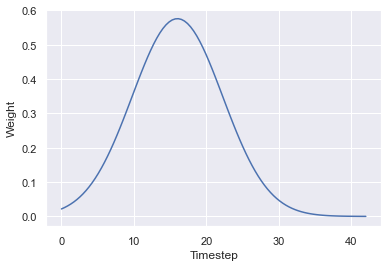

In [11]:
# Select NPI
NPI = "Gatherings_restrictions"
LSTM_predictions, feature_data, SIR_data, weights = [], [], [], []
for day in range(len(SIR_predictions)):
    
    # Compute Gradient instead of using the direct predictions 
    # for scaling/normalization purposes
    gradient = get_gradient(SIR_predictions[day + 1], SIR_predictions[day])
    SIR_data.append(gradient)
        
    # Compute trend of NPI
    y = np.array(NPI_data[NPI])
    z = np.polyfit(np.arange(0, len(NPI_data[NPI])), y, 1)[0]
    
    # Compute new weight, where weight is between 0 and 1,
    # if 0, then influence of the NPI predictions is none, 
    # if 1, then influence of the LSTM model predictions is none.
    weight = compute_weight(z, day, days_delay)
    weights.append(weight)
    
    # Here, the weight of the NPI (z * weight) at timestep i
    # is determined by the delay period (the period between
    # implementing an NPI and the effect on the number of cases).
    result = z * weight
    feature_data.append(result)

# Multivariate LSTM model with SIR based NPI predictions as 
# input feature, along with the number of (previous) 
# confirmed cases (df) and SIR predictions.
model = LSTM(SIR_data=SIR_data, feature=feature_data, input_data=df,
             COUNTRY, FUTURE_DAYS,
             TARGET, TYPE)
model.fit()
LSTM_pred = model.predict(future_days=FUTURE_DAYS)
plotweights(weights)